# Analyzing the Panama Papers with Python & Neo4j

In [4]:
from py2neo import Graph

graph = Graph()

graph.neo4j_version

(3, 0, 1)

## Visualizing the Model

In [5]:
from scripts.vis import draw

options = {
    "Officer": "name",
    "Entity": "name",
    "Intermediary": "name",
    "Address": "address"
}

draw(graph, options, physics=True, limit=30)

## Plotting

In [7]:
%load_ext cypher
import plotly.plotly as py
from plotly.graph_objs import *

The cypher extension is already loaded. To reload it, use:
  %reload_ext cypher


### Which entities have the most beneficiaries?

In [10]:
result = %cypher MATCH (e:Entity)                                                          \
                 RETURN e.name AS entity, size(()-[:BENEFICIARY_OF]->(e)) AS beneficiaries \
                 ORDER BY beneficiaries DESC                                               \
                 LIMIT 5
        
df = result.get_dataframe()
df.head()

5 rows affected.


,entity,beneficiaries
0,T.K.B.K. International Trust,40
1,Worldwide Com-net International Trust,38
2,The Claudius Trust,36
3,Islands International Trust,27
4,Friends of Assisi Trust,26


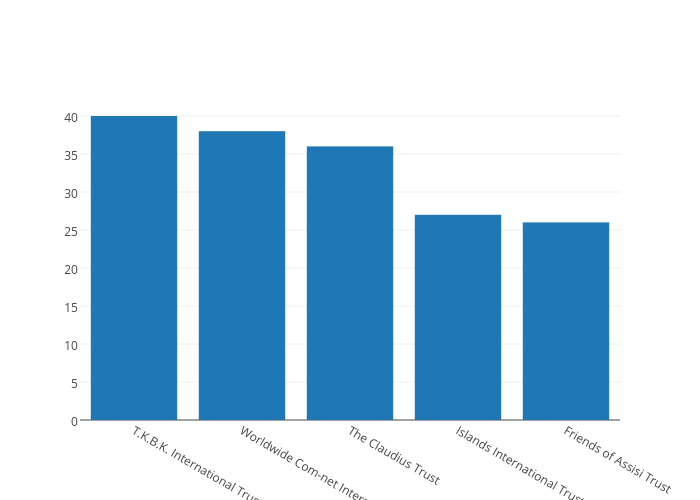

In [11]:
data = Data([Bar(x=df["entity"], y=df["beneficiaries"])])

py.image.ishow({'data': data})

### Heatmap of co-occurrence of shareholders among entities

In [15]:
result = %cypher MATCH (e:Entity)                                                 \
                 WITH e, size(()-[:SHAREHOLDER_OF]->(e)) AS shareholders          \
                 ORDER BY shareholders DESC                                       \
                 LIMIT 50                                                         \
                                                                                  \
                 WITH collect(e) AS top_e                                         \
                 UNWIND top_e AS e1                                               \
                 UNWIND top_e AS e2                                               \
                                                                                  \
                 MATCH (e1)<-[:SHAREHOLDER_OF]-(:Officer)-[:SHAREHOLDER_OF]->(e2) \
                 WHERE e1.name < e2.name                                          \
                 RETURn e1.name, e2.name, count(*) AS weight                      \
                 ORDER BY weight DESC
            
df = result.get_dataframe()
df.head()

20 rows affected.


,e1.name,e2.name,weight
0,DRAGON KING INVESTMENT LTD.,LUK FOOK (CONTROL) LIMITED,72
1,BASINGSTOKE PROPERTY LIMITED,BENBOW HOUSE LIMITED,11
2,WEST END QUAY LIMITED,WESTMEAD PROPERTY HOLDINGS LTD.,8
3,BASINGSTOKE PROPERTY LIMITED,BEACHLEIGH HOLDINGS LIMITED,7
4,BENBOW HOUSE LIMITED,WESTMEAD PROPERTY HOLDINGS LTD.,5


In [13]:
names = list(set(list(df["e1.name"]) + list(df["e2.name"])))
heat = [[0 for i in range(len(names))] for j in range(len(names))] 

for idx, row in df.iterrows():
    i = names.index(row["e1.name"])
    j = names.index(row["e2.name"])
    heat[i][j] = row["weight"]

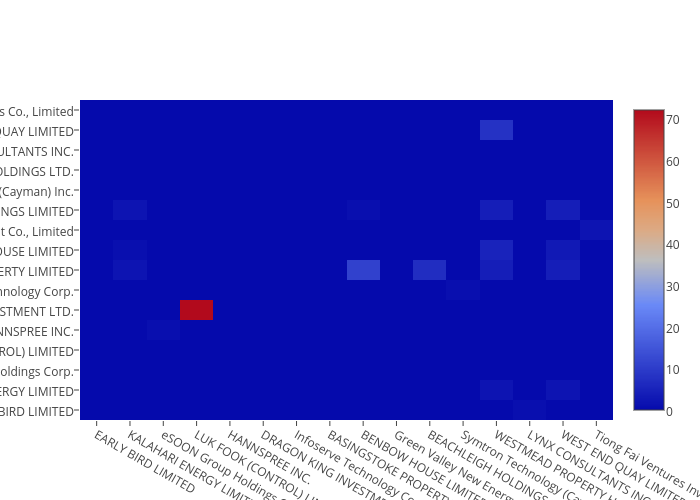

In [14]:
import plotly.graph_objs as go

data = [go.Heatmap(z = heat, x = names, y = names)]
py.image.ishow({'data': data})

## Graph Algorithms

### A subgraph of shareholders

In [24]:
from igraph import Graph as IGraph

query = """
MATCH (o:Officer)
WITH o, size((o)-[:SHAREHOLDER_OF]->()) AS entities
ORDER BY entities DESC
LIMIT 100

WITH collect(o) AS top_o
UNWIND top_o AS o1
UNWIND top_o AS o2

MATCH (o1)-[:SHAREHOLDER_OF]->(:Entity)<-[:SHAREHOLDER_OF]-(o2)
WHERE o1.name < o2.name
RETURn o1.name, o2.name, count(*) AS weight
ORDER BY weight DESC
"""

data = graph.run(query)

ig = IGraph.TupleList(data, weights=True)
ig

### Which officers have the highest betweenness?

$betweenness(v) = \sum_{s, t \in V} \frac{\sigma_{st}(v)}{\sigma_{st}}$

The betweenness centrality of a node $v$ is the number of shortest paths that pass through $v$, $\sigma_{st}(v)$,  divided by the total number of shortest paths, $\sigma_{st}$.

In [25]:
between = [(node["name"], node.betweenness()) for node in ig.vs]
top = sorted(between, key=lambda x: x[1], reverse=True)
top[:5]

[('Helm Trust Company Limited', 58.5),
 ('Minerva Services Limited', 57.0),
 ('Portcullis TrustNet (Samoa) Limited', 47.93333333333334),
 ('Trustcorp Limited', 24.0),
 ('HELM MANAGEMENT LIMITED', 19.5)]

### Community Detection

In [26]:
clusters = IGraph.community_walktrap(ig, weights="weight")
clusters = clusters.as_clustering()
len(clusters)

28

In [28]:
nodes = [{"id": node.index, "label": node["name"]} for node in ig.vs]

for node in nodes:
    node["group"] = clusters.membership[node["id"]]
    
nodes[:5]

[{'group': 0, 'id': 0, 'label': 'BOS NOMINEES (JERSEY) LIMITED'},
 {'group': 0, 'id': 1, 'label': 'BOS SECRETARIES (JERSEY) LIMITED'},
 {'group': 1, 'id': 2, 'label': 'BROCK NOMINEES LIMITED'},
 {'group': 1, 'id': 3, 'label': 'TENBY NOMINEES LIMITED'},
 {'group': 2, 'id': 4, 'label': 'INTERCON LIMITED'}]

In [29]:
edges = [{"from": x[0], "to": x[1]} for x in ig.get_edgelist()]
edges[:5]

[{'from': 0, 'to': 1},
 {'from': 2, 'to': 3},
 {'from': 4, 'to': 5},
 {'from': 6, 'to': 7},
 {'from': 7, 'to': 8}]

In [30]:
from scripts.vis import vis_network
vis_network(nodes, edges, physics=True)